In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)
# colors = ["#95D3A2", "#FFFFBF", "#F79051", ]
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

SAVE_PATH = r"E:\MS_ExperimentData\general"
# SAVE_PATH = r"D:\MS_ExperimentData\general"

In [108]:
class PathPlanningGSCD(PathPlanningGSC):
    def __init__(self, nodePosition, productRateBetac = 1, decayRateKc = 0.001, 
                 diffusionRateDc = 1, convectionVc = 1, 
                 cDecayBase = 0.8, cControlThres = 0.5, 
                 noiseRateBetaDp = 0.1, initialState = 0.5, chemoAlphaC = 1, 
                 diameter = 0.1, repelPower = 1, repCutOff = True, deltaSpread = False, 
                 cellNumInLine = 200, boundaryLength = 200, 
                 agentsNum = 1000, dt = 0.1, tqdm = False, savePath = None, shotsnaps = 10, 
                 randomSeed = 10, overWrite = False):
        super().__init__(nodePosition, productRateBetac, decayRateKc, diffusionRateDc, 
                         convectionVc, cDecayBase, cControlThres, noiseRateBetaDp, 
                         initialState, chemoAlphaC, diameter, repelPower, repCutOff, 
                         deltaSpread, cellNumInLine, boundaryLength, agentsNum, dt, 
                         tqdm, savePath, shotsnaps, randomSeed, overWrite)
        self.v = np.zeros((cellNumInLine, cellNumInLine))

    @property
    def dotC(self):
        return (
            self.diffusionRateDc * self.nabla2C
            - self.decayRateKc * self.c
            + self.productC
            # + self.c**2 * self.v
        )
    
    @property
    def dotV(self):
        b = 0.011
        return (
            5 * self.nabla2V
            + b
            - self.c**2 * self.v
        )
    
    def update(self):
        dotC = self.dotC
        dotV = self.dotV

        self.c += dotC * self.dt
        self.v += dotV * self.dt
        self.c[self.c < 0] = 0
        self.v[self.v < 0] = 0

In [109]:
pathShift = 25
center = 100
patternHalfLength = 20
nodePosition = np.array([
    [100 - pathShift, 100], [100 + pathShift, 100]
])

model = PathPlanningGSCD(nodePosition, tqdm=True)
model.run(8000)

  0%|          | 0/8000 [00:00<?, ?it/s]

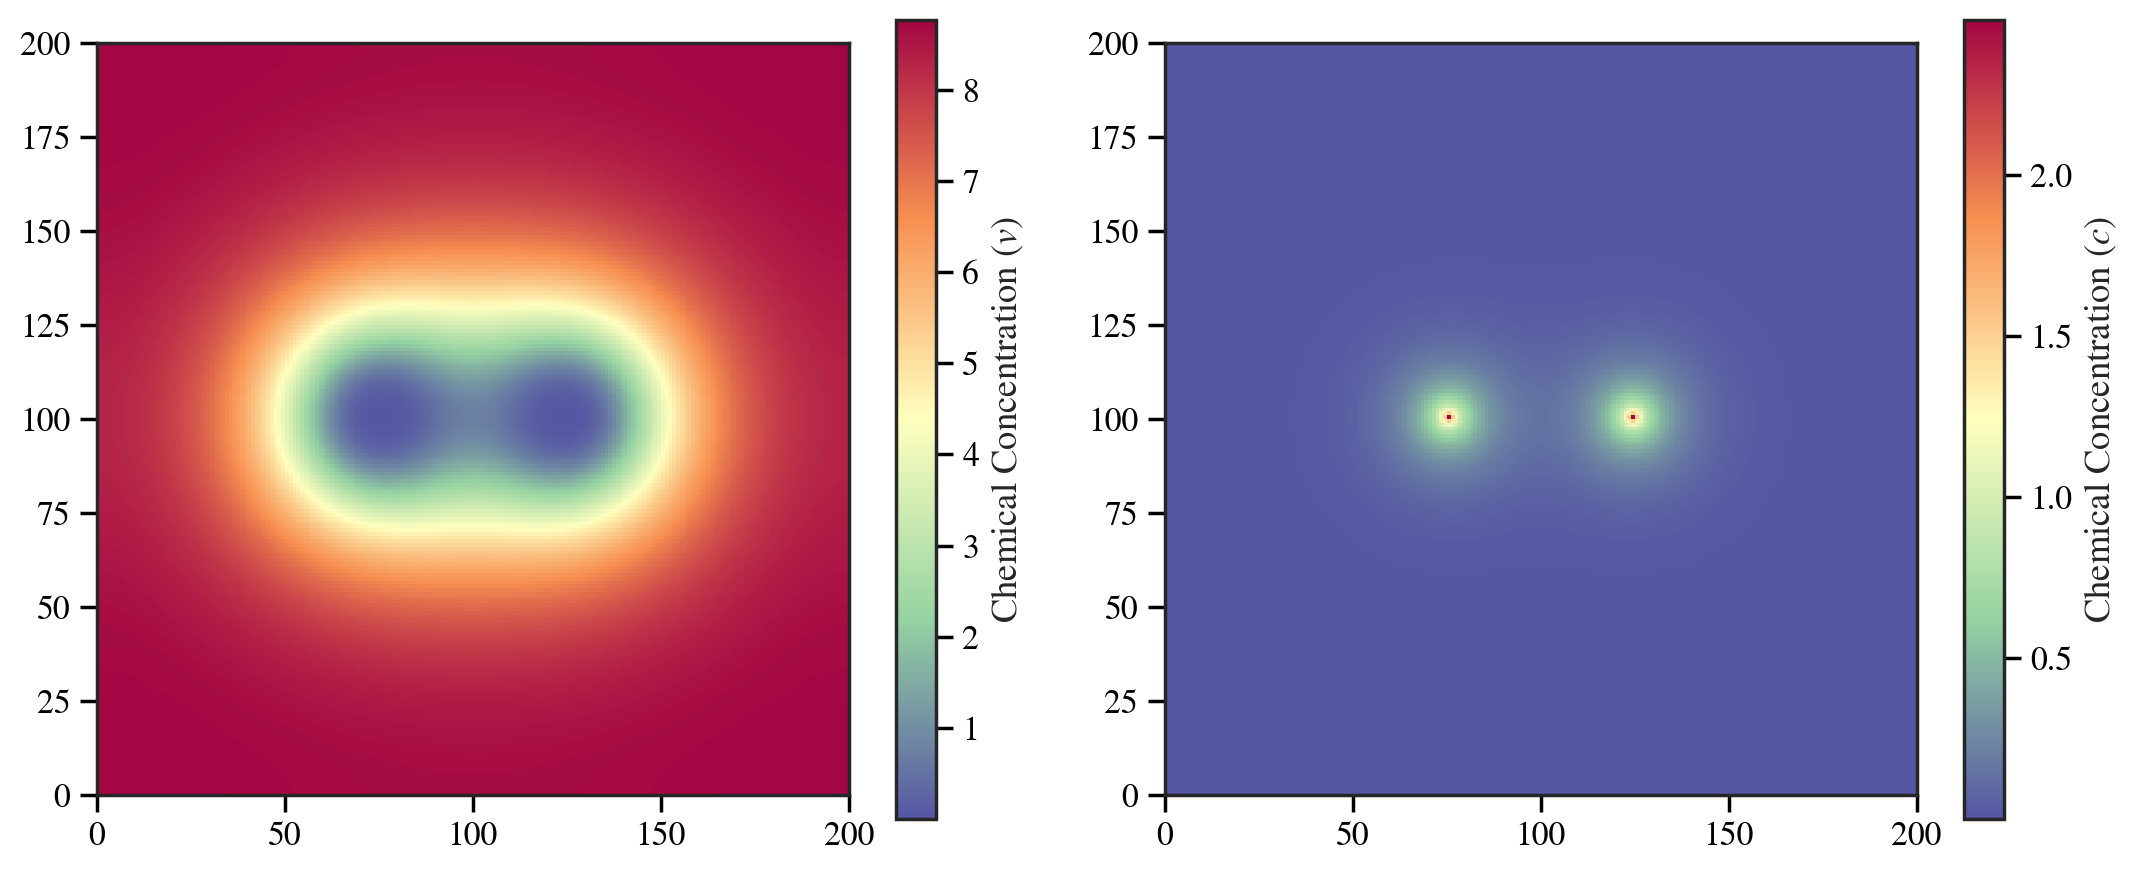

In [110]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5))

ax = axs[0]
im = ax.imshow(model.v.T, cmap=cmap, 
               extent=(0, model.boundaryLength, 0, model.boundaryLength),
               origin="lower", alpha=1, zorder=0)
plt.colorbar(im, ax=ax, label="Chemical Concentration ($v$)")

ax = axs[1]
im = ax.imshow(model.c.T, cmap=cmap, 
               extent=(0, model.boundaryLength, 0, model.boundaryLength),
               origin="lower", alpha=1, zorder=0)
plt.colorbar(im, ax=ax, label="Chemical Concentration ($c$)")

for ax in axs:
    ax.set_xlim(0, model.boundaryLength)
    ax.set_ylim(0, model.boundaryLength)

plt.tight_layout()

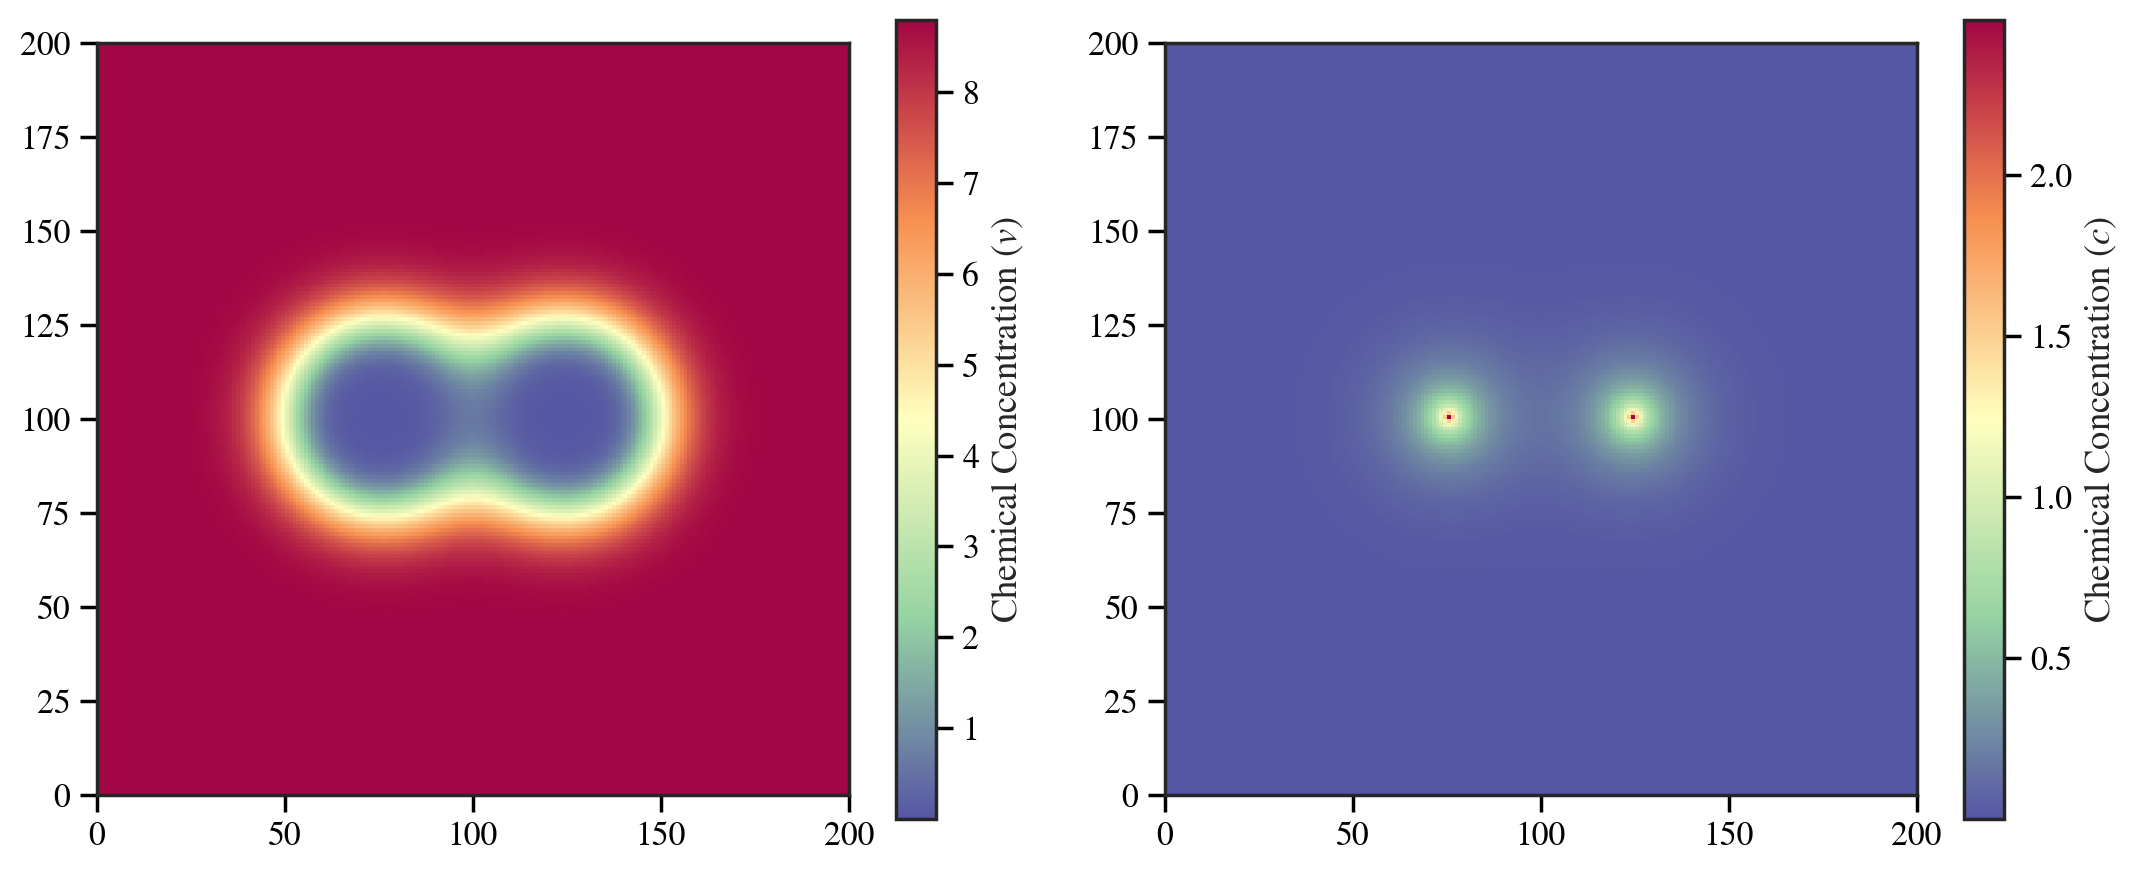